In [1]:
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *

path = "C:/DAT255/CovPneNorData"

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),   
    get_items=get_image_files,            
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  
    get_y=parent_label,                  
    item_tfms=Resize(128)
)

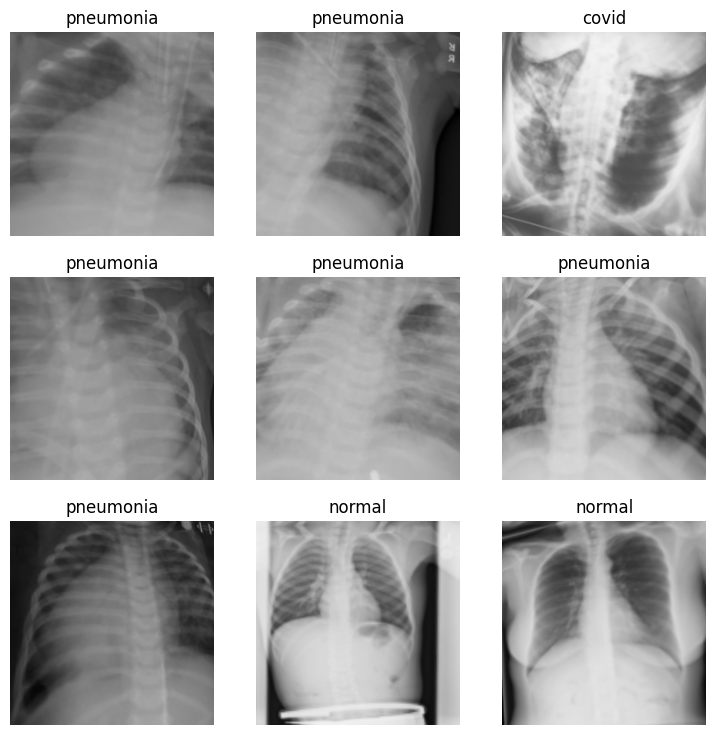

In [3]:
dls = datablock.dataloaders(path, batch_size=128)

dls.show_batch(max_n=9)

In [4]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\johan/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:03<00:00, 24.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.013675,0.416429,0.143382,05:16


epoch,train_loss,valid_loss,error_rate,time
0,0.435451,0.314252,0.122549,06:25
1,0.353595,0.279065,0.061275,06:16
2,0.269364,0.236550,0.053922,06:07
3,0.218698,0.198768,0.051471,06:06


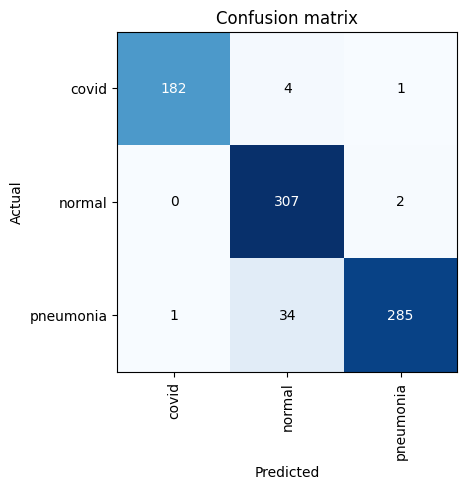

In [5]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

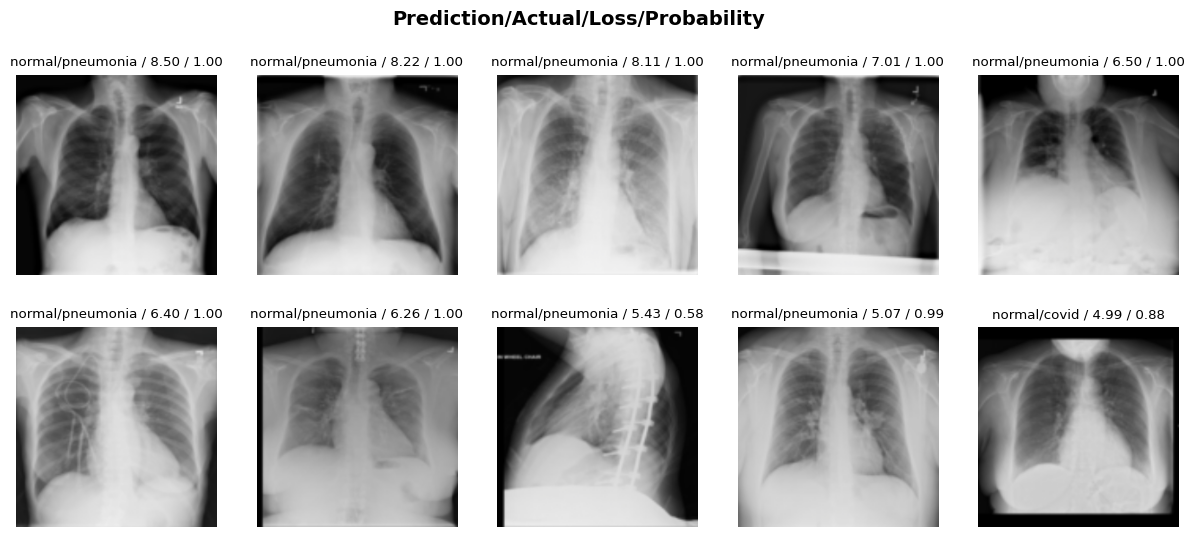

In [6]:
with plt.rc_context({'font.size': 8}):
    interp.plot_top_losses(10, nrows=2)

In [9]:
learn.export('chestv1.pkl')

In [10]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('chestv1.pkl')]

In [11]:
 learn_inf = load_learner(path/'chestv1.pkl')

In [72]:
import ipywidgets as widgets
from IPython.display import display
btn_upload = widgets.FileUpload()
display(btn_upload)

FileUpload(value=(), description='Upload')

In [119]:
uploaded_file_details = btn_upload.value[0]
content = uploaded_file_details['content']
img = PILImage.create(io.BytesIO(content))

out_pl = widgets.Output()
out_pl.clear_output()
display(out_pl)

with out_pl:
    display(img.to_thumb(256,256))
    

pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred


Output()

Label(value='Prediction: covid; Probability: 0.9996')

In [120]:
x, = first(dls.test_dl([img]))

In [121]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

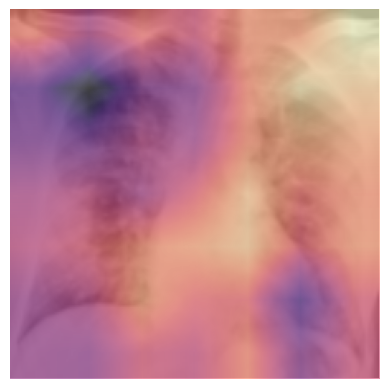

In [128]:
import numpy as np

with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cpu())
    act = hook.stored

with torch.no_grad(): output = learn.model.eval()(x)

cam_map = torch.einsum('ck,bkij->bcij', learn.model[1][-1].weight, act)
cam_map.shape

x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
cam_normalized = (cam_map[0, 1] - cam_map[0, 1].min()) / (cam_map[0, 1].max() - cam_map[0, 1].min())
cam_normalized = cam_normalized.detach().cpu()  # Detach and move to CPU

threshold_value = 0.01
cam_thresholded = torch.where(cam_normalized > threshold_value, cam_normalized, torch.zeros_like(cam_normalized))


ax.imshow(cam_thresholded.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma_r');